# NLP - Ham/Spam Analysis

we will discuss a higher level overview of the basics of Natural Language Processing, which basically consists of combining machine learning techniques with text, and using math and statistics to get that text in a format that the machine learning algorithms can understand!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter

from sklearn.preprocessing import LabelEncoder, scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, f1_score
from sklearn.linear_model import LogisticRegression

import string
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import nltk
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download("averaged_perceptron_tagger")

import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fatih\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fatih\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fatih\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\fatih\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\fatih\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\fatih\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]    

## Get the Data

We'll be using a dataset from the [UCI datasets](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection)! This dataset is already located in the folder for this section.

The file we are using contains a collection of more than 5 thousand SMS phone messages. You can check out the **readme** file for more info.

Let's go ahead and use rstrip() plus a list comprehension to get a list of all the lines of text messages:

In [2]:
messages = [line.rstrip() for line in open('SMSSpamCollection')]
print(len(messages))

5574


A collection of texts is also sometimes called "corpus". Let's print the first ten messages and number them using **enumerate**:

In [3]:
messages[:10]

['ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
 'ham\tOk lar... Joking wif u oni...',
 "spam\tFree entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
 'ham\tU dun say so early hor... U c already then say...',
 "ham\tNah I don't think he goes to usf, he lives around here though",
 "spam\tFreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv",
 'ham\tEven my brother is not like to speak with me. They treat me like aids patent.',
 "ham\tAs per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
 'spam\tWINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. 

In [4]:
for message_no, message in enumerate(messages[:10]):
    print(message_no, message)
    print('\n')

0 ham	Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...


1 ham	Ok lar... Joking wif u oni...


2 spam	Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's


3 ham	U dun say so early hor... U c already then say...


4 ham	Nah I don't think he goes to usf, he lives around here though


5 spam	FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, Â£1.50 to rcv


6 ham	Even my brother is not like to speak with me. They treat me like aids patent.


7 ham	As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune


8 spam	WINNER!! As a valued network customer you have been selected to receivea Â£900 prize reward! To claim call 09061701461. Claim cod

Due to the spacing we can tell that this is a [TSV](http://en.wikipedia.org/wiki/Tab-separated_values) ("tab separated values") file, where the first column is a label saying whether the given message is a normal message (commonly known as "ham") or "spam". The second column is the message itself. (Note our numbers aren't part of the file, they are just from the **enumerate** call).

Using these labeled ham and spam examples, we'll **train a machine learning model to learn to discriminate between ham/spam automatically**. Then, with a trained model, we'll be able to **classify arbitrary unlabeled messages** as ham or spam.

We'll use **read_csv** and make note of the **sep** argument, we can also specify the desired column names by passing in a list of *names*.

In [5]:
messages = pd.read_csv('SMSSpamCollection', sep='\t', names=["label", "message"])
messages.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## Exploratory Data Analysis

Let's check out some of the stats with some plots and the built-in methods in pandas!

In [6]:
messages.describe()

,label,message
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


Let's use **groupby** to use describe by label, this way we can begin to think about the features that separate ham and spam!

In [7]:
messages.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

As we continue our analysis we want to start thinking about the features we are going to be using. This goes along with the general idea of [feature engineering](https://en.wikipedia.org/wiki/Feature_engineering). The better your domain knowledge on the data, the better your ability to engineer more features from it. Feature engineering is a very large part of spam detection in general. I encourage you to read up on the topic!

Let's make a new column to detect how long the text messages are:

In [8]:
messages['length'] = messages['message'].apply(len)
messages.head()

,label,message,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


### Data Visualization

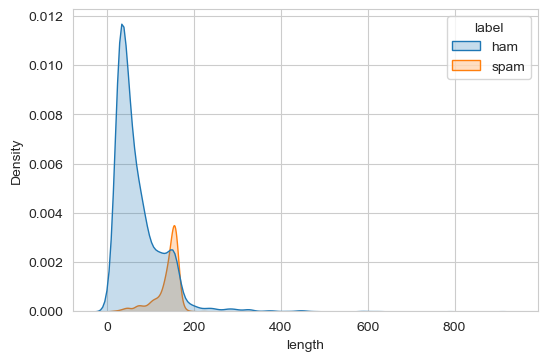

In [9]:
sns.kdeplot(x='length',data=messages,hue='label',shade=True);

In [10]:
messages.groupby('label').describe()

length                                                         
        count        mean        std   min    25%    50%    75%    max
label                                                                 
ham    4825.0   71.482487  58.440652   2.0   33.0   52.0   93.0  910.0
spam    747.0  138.670683  28.873603  13.0  133.0  149.0  157.0  223.0

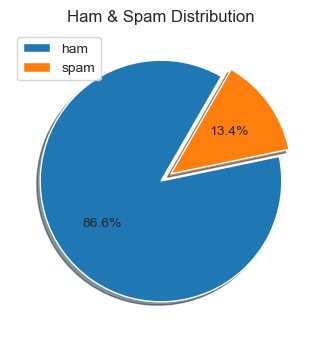

In [11]:
explode = [0,0.1]
plt.pie(messages['label'].value_counts(),explode=explode, autopct='%1.1f%%',shadow=True,startangle=60)
plt.legend(labels=['ham', 'spam'])
plt.title('Ham & Spam Distribution')
plt.axis('off')
plt.show()

Woah! 910 characters, let's use masking to find this message:

In [12]:
messages[messages['length'] == 910]['message'].iloc[0]

"For me the love should start with attraction.i should feel that I need her every time around me.she should be the first thing which comes in my thoughts.I would start the day and end it with her.she should be there every time I dream.love will be then when my every breath has her name.my life should happen around her.my life will be named to her.I would cry for her.will give all my happiness and take all her sorrows.I will be ready to fight with anyone for her.I will be in love when I will be doing the craziest things for her.love will be when I don't have to proove anyone that my girl is the most beautiful lady on the whole planet.I will always be singing praises for her.love will be when I start up making chicken curry and end up makiing sambar.life will be the most beautiful then.will get every morning and thank god for the day because she is with me.I would like to say a lot..will tell later.."

Looks like we have some sort of Romeo sending texts! But let's focus back on the idea of trying to see if message length is a distinguishing feature between ham and spam:

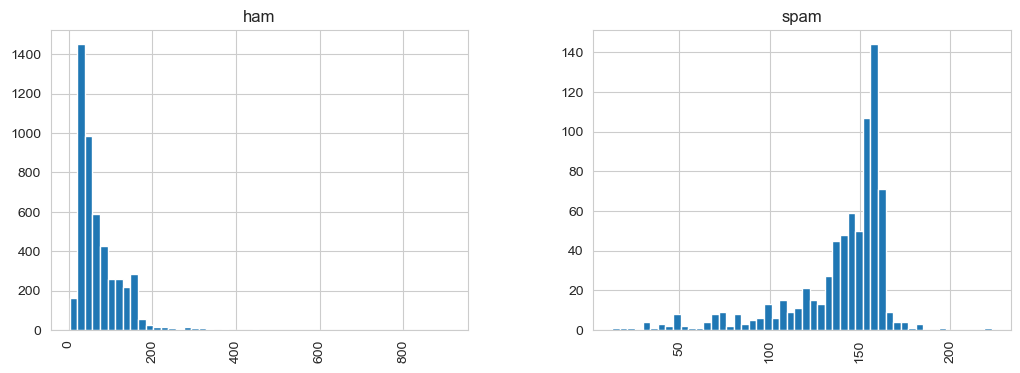

In [13]:
messages.hist(column='length', by='label', bins=50,figsize=(12,4));

Very interesting! Through just basic EDA we've been able to discover a trend that spam messages tend to have more characters. (Sorry Romeo!)

Now let's begin to process the data so we can eventually use it with SciKit Learn!

## Text Pre-processing

In [14]:
stop_words=stopwords.words('english')
lem=WordNetLemmatizer()

def cleaning(data):
    #1. Tokenize
    text_tokens=word_tokenize(data) 
    # Ozel isimlerle calismayacaksaniz, hepsini lowercase yapariz: word_tokenize(data.lower()) 
    
    #2. Remove Punc
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    
    #3. Remove stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    
    #4. Lemmatize
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]
    
    #5. Joinning
    return ' '.join(text_cleaned)

In [15]:
messages['message_2']=messages['message'].apply(cleaning)
messages.head(2)

,label,message,length,message_2
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go jurong point crazy Available bugis n great ...
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni


**Tokenization**

In [16]:
messages['message_3']=messages['message_2'].apply(lambda x: x.split())
messages.head(2)

,label,message,length,message_2,message_3
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go jurong point crazy Available bugis n great ...,"[Go, jurong, point, crazy, Available, bugis, n..."
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni,"[Ok, lar, Joking, wif, u, oni]"


**PoST**

In [17]:
messages['message_4']=messages['message_3'].apply(lambda x: nltk.pos_tag(x))
messages.head(2)

,label,message,length,message_2,message_3,message_4
0,ham,"Go until jurong point, crazy.. Available only ...",111,Go jurong point crazy Available bugis n great ...,"[Go, jurong, point, crazy, Available, bugis, n...","[(Go, VB), (jurong, JJ), (point, NN), (crazy, ..."
1,ham,Ok lar... Joking wif u oni...,29,Ok lar Joking wif u oni,"[Ok, lar, Joking, wif, u, oni]","[(Ok, NNP), (lar, JJ), (Joking, NNP), (wif, NN..."


### Continuing Normalization

There are a lot of ways to continue normalizing this text. Such as [Stemming](https://en.wikipedia.org/wiki/Stemming) or distinguishing by [part of speech](http://www.nltk.org/book/ch05.html).

NLTK has lots of built-in tools and great documentation on a lot of these methods. Sometimes they don't work well for text-messages due to the way a lot of people tend to use abbreviations or shorthand, For example:
    
    'Nah dawg, IDK! Wut time u headin to da club?'
    
versus

    'No dog, I don't know! What time are you heading to the club?'
    
Some text normalization methods will have trouble with this type of shorthand and so I'll leave you to explore those more advanced methods through the [NLTK book online](http://www.nltk.org/book/).

For now we will just focus on using what we have to convert our list of words to an actual vector that SciKit-Learn can use.

**Feature Engineering**
* Count Vectors
* TF-IDF Vectors
* Word Embedding

**Splitting Data**

In [18]:
X=messages['message_2']
y=messages['label']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [19]:
X_train.head()

708     Quite late lar Ard anyway wun b drivin
4338                    Tuesday night r u real
5029              Go chase run crossing street
4921                   G say never answer text
2592              Still work going small house
Name: message_2, dtype: object

In [20]:
y_train.tail(5)

3772    ham
5191    ham
5226    ham
5390    ham
860     ham
Name: label, dtype: object

**LabelEncoder**

In [21]:
# from sklearn.preprocessing import LabelEncoder
encoder=LabelEncoder()
y_train=encoder.fit_transform(y_train)
y_test=encoder.transform(y_test)

## Vectorization

In [22]:
# from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
vectorizer= CountVectorizer()
X_train_vectorized=vectorizer.fit_transform(X_train)
X_test_vectorized=vectorizer.transform(X_test)

In [23]:
X_train_vectorized.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [24]:
pd.DataFrame(X_train_vectorized.toarray()).tail(5)

,0,1,2,3,4,5,6,7,8,9,...,5814,5815,5816,5817,5818,5819,5820,5821,5822,5823
3895,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3896,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3897,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3898,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3899,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### So what is TF-IDF?
TF-IDF stands for *term frequency-inverse document frequency*, and the tf-idf weight is a weight often used in information retrieval and text mining. This weight is a statistical measure used to evaluate how important a word is to a document in a collection or corpus. The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus. Variations of the tf-idf weighting scheme are often used by search engines as a central tool in scoring and ranking a document's relevance given a user query.

One of the simplest ranking functions is computed by summing the tf-idf for each query term; many more sophisticated ranking functions are variants of this simple model.

Typically, the tf-idf weight is composed by two terms: the first computes the normalized Term Frequency (TF), aka. the number of times a word appears in a document, divided by the total number of words in that document; the second term is the Inverse Document Frequency (IDF), computed as the logarithm of the number of the documents in the corpus divided by the number of documents where the specific term appears.

**TF: Term Frequency**, which measures how frequently a term occurs in a document. Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones. Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

*TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).*

**IDF: Inverse Document Frequency**, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

*IDF(t) = log_e(Total number of documents / Number of documents with term t in it).*

See below for a simple example.

**Example:**

Consider a document containing 100 words wherein the word cat appears 3 times. 

The term frequency (i.e., tf) for cat is then (3 / 100) = 0.03. Now, assume we have 10 million documents and the word cat appears in one thousand of these. Then, the inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = 4. Thus, the Tf-idf weight is the product of these quantities: 0.03 * 4 = 0.12.
____

Let's go ahead and see how we can do this in SciKit Learn:

In [25]:
tf_idf_vectorizer=TfidfVectorizer()
X_train_tf_idf = tf_idf_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_vectorizer.transform(X_test)

In [26]:
pd.DataFrame(X_train_tf_idf.toarray()).head(5)

,0,1,2,3,4,5,6,7,8,9,...,5814,5815,5816,5817,5818,5819,5820,5821,5822,5823
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training a Model

In [27]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB

### 1-Naive Bayes classifier
With messages represented as vectors, we can finally train our spam/ham classifier. Now we can actually use almost any sort of classification algorithms. For a [variety of reasons](http://www.inf.ed.ac.uk/teaching/courses/inf2b/learnnotes/inf2b-learn-note07-2up.pdf), the Naive Bayes classifier algorithm is a good choice.

In [28]:
# from sklearn.naive_bayes import MultinomialNB
naive_bayes= MultinomialNB()
naive_bayes.fit(X_train_vectorized,y_train)
y_pred=naive_bayes.predict(X_test_vectorized)

In [29]:
print('Confusion Matrix:',*confusion_matrix(y_test,y_pred), sep="\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[1433   15]
[ 15 209]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1448
           1       0.93      0.93      0.93       224

    accuracy                           0.98      1672
   macro avg       0.96      0.96      0.96      1672
weighted avg       0.98      0.98      0.98      1672



In [30]:
nb_accuracy = naive_bayes.score(X_test_vectorized,y_test)
nb_f1_score = f1_score(y_test, y_pred, average='macro')
print('nb_accuracy:',nb_accuracy,
      '\nnb_f1_score:',nb_f1_score)

nb_accuracy: 0.9820574162679426 
nb_f1_score: 0.9613382991318074


### 2-Logistic Regression

In [31]:
log_model=LogisticRegression()
log_model.fit(X_train_vectorized,y_train)
y_pred=log_model.predict(X_test_vectorized)

In [32]:
print('Confusion Matrix:',*confusion_matrix(y_test,y_pred), sep="\n")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[1444    4]
[ 29 195]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1448
           1       0.98      0.87      0.92       224

    accuracy                           0.98      1672
   macro avg       0.98      0.93      0.96      1672
weighted avg       0.98      0.98      0.98      1672



In [33]:
log_accuracy = log_model.score(X_test_vectorized,y_test)
log_f1_score = f1_score(y_test, y_pred, average='macro')
print('log_accuracy:',log_accuracy,
      '\nlog_f1_score:',log_f1_score)

log_accuracy: 0.9802631578947368 
log_f1_score: 0.9553441573734828


**Model Evaluation**

We can use SciKit Learn's built-in classification report, which returns [precision, recall,](https://en.wikipedia.org/wiki/Precision_and_recall) [f1-score](https://en.wikipedia.org/wiki/F1_score), and a column for support (meaning how many cases supported that classification). Check out the links for more detailed info on each of these metrics and the figure below:

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png' width=400 />

There are quite a few possible metrics for evaluating model performance. Which one is the most important depends on the task and the business effects of decisions based off of the model. For example, the cost of mis-predicting "spam" as "ham" is probably much lower than mis-predicting "ham" as "spam".

In the above "evaluation",we evaluated accuracy on the same data we used for training. **You should never actually evaluate on the same dataset you train on!**

Such evaluation tells us nothing about the true predictive power of our model. If we simply remembered each example during training, the accuracy on training data would trivially be 100%, even though we wouldn't be able to classify any new messages.

A proper way is to split the data into a training/test set, where the model only ever sees the **training data** during its model fitting and parameter tuning. The **test data** is never used in any way. This is then our final evaluation on test data is representative of true predictive performance.


# ``Accuracy & F1 Score Comparison``

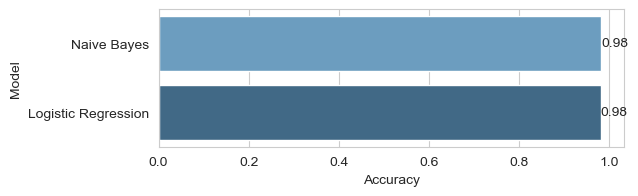

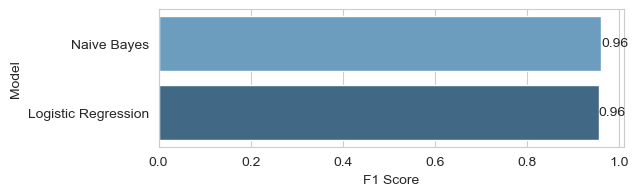

In [34]:
compare = pd.DataFrame({"Model": ["Logistic Regression",'Naive Bayes'],
                        "Accuracy": [log_accuracy, nb_accuracy],
                        "F1 Score": [log_f1_score, nb_f1_score]})

def labels(ax):
    for p in ax.patches:
        width = p.get_width()    # get bar length
        ax.text(width,       # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                '{:1.2f}'.format(width), # set variable to display, 2 decimals
                ha = 'left',   # horizontal alignment
                va = 'center')  # vertical alignment
    
plt.subplot(211)
compare = compare.sort_values(by="Accuracy", ascending=False)
ax=sns.barplot(x="Accuracy", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show()

plt.subplot(212)
compare = compare.sort_values(by="F1 Score", ascending=False)
ax=sns.barplot(x="F1 Score", y="Model", data=compare, palette="Blues_d")
labels(ax)
plt.show()